In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm


from helpers import generate_embedding
from graph_randomisation import run_parallel_tempering, MCMC_Chain, compute_entropy_mean, compute_entropy_variance, infinite_temp_entropy, compute_specific_heat_mean, compute_specific_heat_variance,\
compute_entropy_free_energy


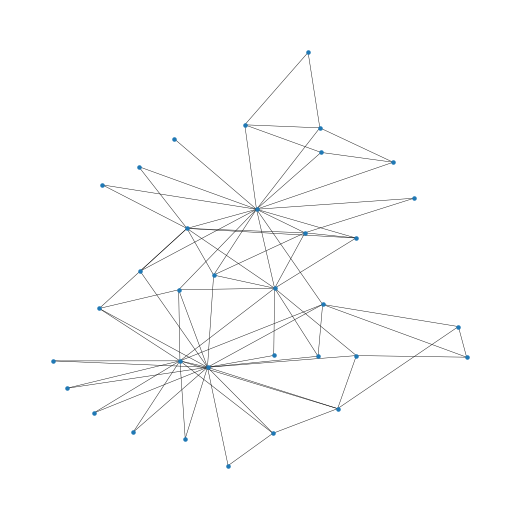

In [11]:
G = nx.karate_club_graph()
#G = nx.read_gml('celegansneural.gml', label='id').to_undirected()

for u, v in G.edges():
    G[u][v].clear()
G.remove_edges_from(nx.selfloop_edges(G))
G= nx.convert_node_labels_to_integers(G, first_label=0)
N = len(G.nodes)

positions = nx.kamada_kawai_layout(G)
fig = plt.figure(figsize=(5, 5))
nx.draw(G, pos = positions, node_size=5, width=0.3)

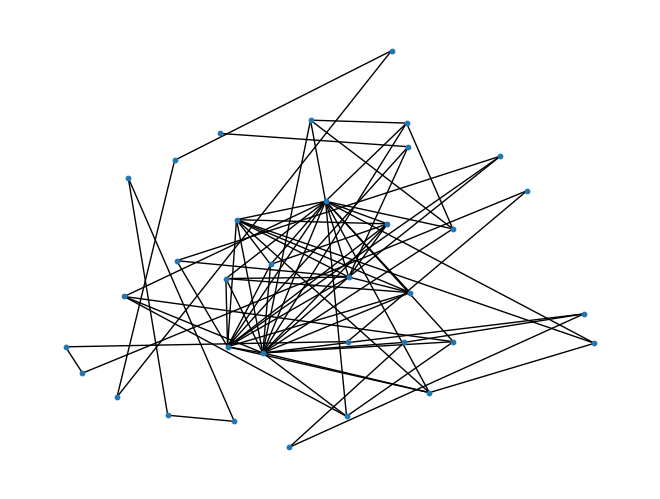

In [13]:
starting_graph = nx.havel_hakimi_graph([degree for node, degree in G.degree()])
nx.draw(starting_graph, pos=positions, node_size=10)

In [ ]:
states, minimum_edgelists, min_diffs, diffs_by_temp, samples, betas = run_parallel_tempering(target_graph=G, 
                                                                                             starting_graph=starting_graph, 
                                                                                             n_steps =1000000, 
                                                                                             burn_in=800000, 
                                                                                             K = 14, 
                                                                                             directed=False,
                                                                                             alpha=None, 
                                                                                             normalise_embedding=True, 
                                                                                             operation='both',
                                                                                             n_states=50,
                                                                                             beta_min = 0,
                                                                                             beta_max=80,
                                                                                             swap_steps=1000,
                                                                                             swap_interval = 1000,
                                                                                             print_outputs=True,
                                                                                             combine_embeddings=False,
                                                                                             sample=True,
                                                                                             #betas = np.concatenate(([0], np.geomspace(4, 1000, 40), np.linspace(1000.1, 3000, 60))),
                                                                                             p=0.4)


In [41]:
sampled_graphs = {beta: [] for beta in betas}
for b in betas:
    for i in range(len(samples[b])):
        sampled_graph = nx.Graph() ; sampled_graph.add_nodes_from(list(G.nodes))
        sampled_graph.add_edges_from(samples[b][i])
        sampled_graphs[b].append(sampled_graph.copy())

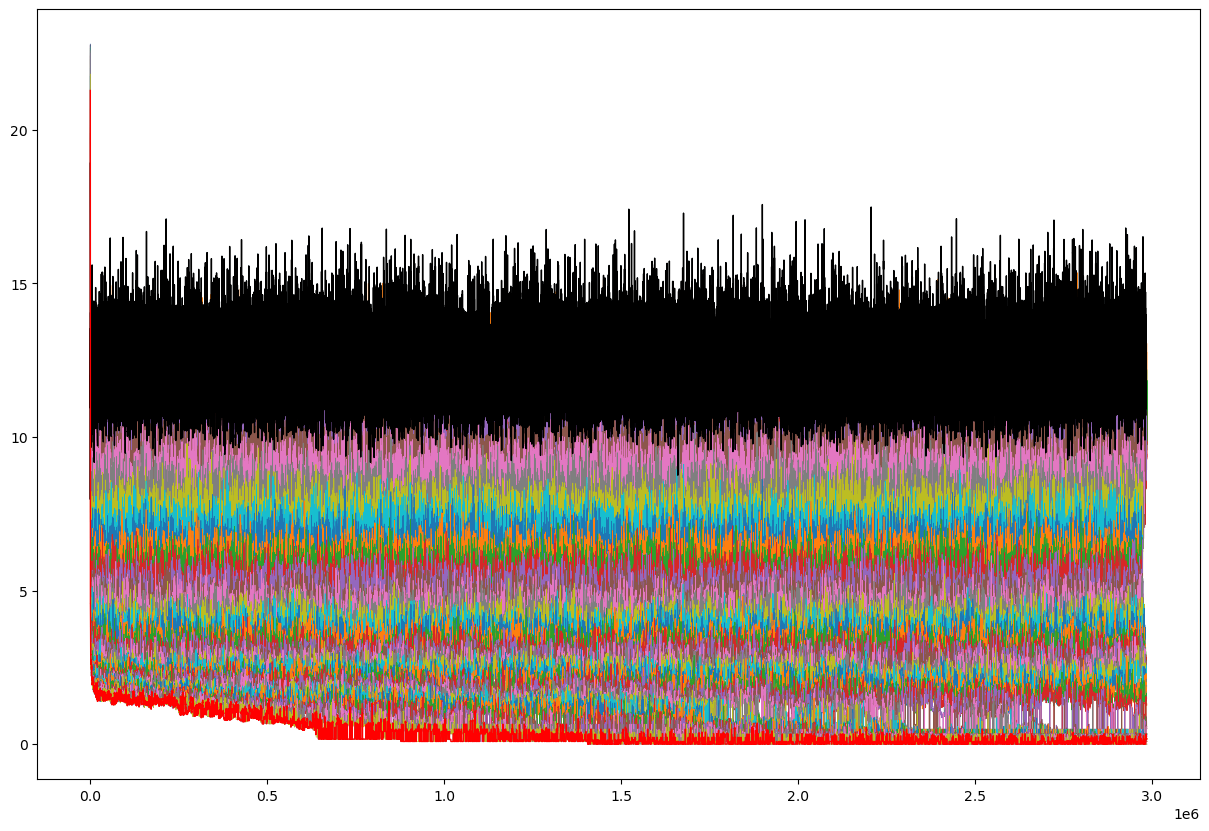

In [67]:
fig = plt.figure(figsize=(15, 10))
for b in betas:
    plt.plot(diffs_by_temp[b], linewidth=0.5)

plt.plot(diffs_by_temp[betas[0]], linewidth=1, color='k')
plt.plot(diffs_by_temp[betas[-1]], linewidth=1, color='r')

In [69]:
A1 = np.eye(N) - nx.normalized_laplacian_matrix(G)
#A1 = np.eye(N) - nx.directed_laplacian_matrix(G, walk_type='pagerank', alpha=0.85)
val1, vec1 = np.linalg.eigh(A1)


#beta=0
randomised_graphs = sampled_graphs[betas[0]]
vals = np.zeros((len(randomised_graphs), N))
for i in tqdm(range(len(randomised_graphs))):
    A3 = np.eye(N) - nx.normalized_laplacian_matrix(randomised_graphs[i])
    #A3 = np.eye(N) - nx.directed_laplacian_matrix(randomised_graphs[i], walk_type='pagerank', alpha=0.85)
    vals[i] = np.linalg.eigh(A3)[0]

val0 = np.mean(vals, axis=0)
std_vals0 = np.std(vals, axis=0)

#beta=20
randomised_graphs = sampled_graphs[betas[20]]
#randomised_graphs = sampled_graphs[betas[]] #500
vals = np.zeros((len(randomised_graphs), N))
for i in tqdm(range(len(randomised_graphs))):
    A3 = np.eye(N) - nx.normalized_laplacian_matrix(randomised_graphs[i])
    #A3 = np.eye(N) - nx.directed_laplacian_matrix(randomised_graphs[i], walk_type='pagerank', alpha=0.85)
    vals[i] = np.linalg.eigh(A3)[0]

val20 = np.mean(vals, axis=0)
std_vals20 = np.std(vals, axis=0)

#beta=30
randomised_graphs = sampled_graphs[betas[30]]
#randomised_graphs = sampled_graphs[betas[91]] #5000
vals = np.zeros((len(randomised_graphs), N))
for i in tqdm(range(len(randomised_graphs))):
    A3 = np.eye(N) - nx.normalized_laplacian_matrix(randomised_graphs[i])
    #A3 = np.eye(N) - nx.directed_laplacian_matrix(randomised_graphs[i], walk_type='pagerank', alpha=0.85)
    vals[i] = np.linalg.eigh(A3)[0]

val30 = np.mean(vals, axis=0)
std_vals30 = np.std(vals, axis=0)

#beta=50
randomised_graphs = sampled_graphs[betas[-1]]
vals = np.zeros((len(randomised_graphs), N))
for i in tqdm(range(len(randomised_graphs))):
    A3 = np.eye(N) - nx.normalized_laplacian_matrix(randomised_graphs[i])
    #A3 = np.eye(N) - nx.directed_laplacian_matrix(randomised_graphs[i], walk_type='pagerank', alpha=0.85)
    vals[i] = np.linalg.eigh(A3)[0]

val50 = np.mean(vals, axis=0)
std_vals50 = np.std(vals, axis=0)

100%|███████████████████████████████████████| 301/301 [00:00<00:00, 2740.13it/s]


(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25]),
 [Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

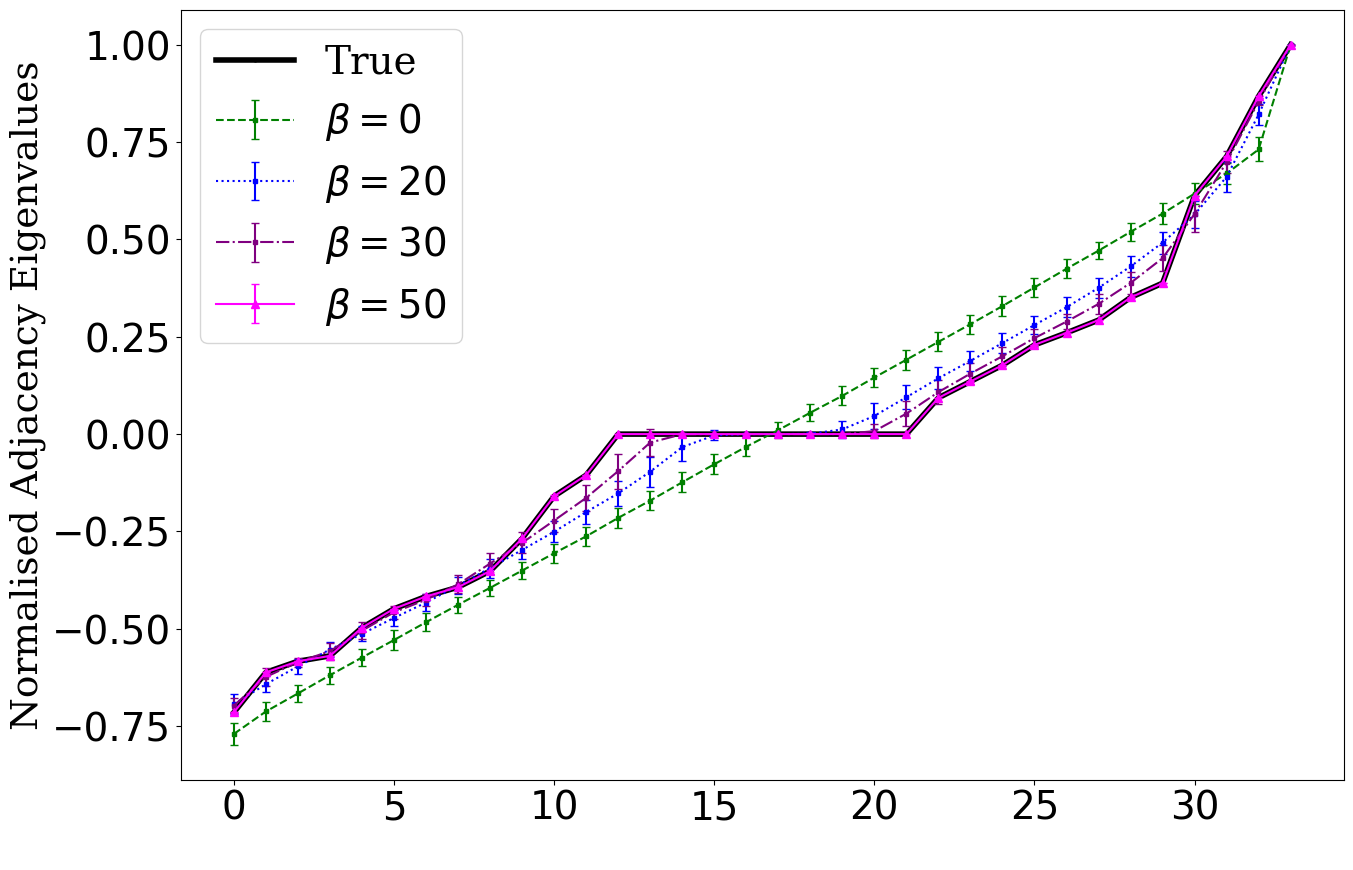

In [71]:
fig = plt.figure(figsize=(15, 10))
plt.plot(val1, 'k', label='True', marker='o', markersize=2, linewidth=4)

plt.errorbar(np.arange(N), val0, yerr = std_vals0, marker='s', capsize=3, markersize=3, linestyle='--', label=r'$\beta=0$', color='g')
plt.errorbar(np.arange(N), val20, yerr = std_vals20, marker='s', capsize=3, markersize=3, label=r'$\beta=20$', color='blue', linestyle='dotted')
plt.errorbar(np.arange(N), val30, yerr = std_vals30, marker='s', capsize=3, markersize=3, label=r'$\beta=30$', color='purple', linestyle='dashdot')
plt.errorbar(np.arange(N), val50, yerr = std_vals50, marker='^', capsize=3, markersize=6, label=r'$\beta=50$', color='magenta')


plt.legend(prop={'family':'serif', 'size':28})
plt.ylabel('Normalised Adjacency Eigenvalues', fontsize=27, font='serif')
plt.xlabel(' ', fontsize=20, font='serif')
plt.xticks(fontsize=28) ; plt.yticks(fontsize=28)

#plt.savefig('KC_spectra final.pdf', bbox_inches='tight')




In [75]:
def CC_correlation(CCs, true):
    corr = np.corrcoef(true, CCs)[0, 1]
    return corr

correlations1 = np.zeros((len(betas), 3))

centrality = lambda G : nx.clustering(G)

true = centrality(G)

for i in tqdm(range(len(betas))):
    randomised_graphs = sampled_graphs[betas[i]]
    corrs = []
    for j in randomised_graphs:
        CC = centrality(j)
        corrs.append(CC_correlation(list(CC.values()), list(true.values())))
        
    correlations1[i, 0]  = np.median(corrs)
    correlations1[i, 1:] = np.percentile(corrs, [25, 75])

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.66it/s]


In [20]:
len(sampled_graphs[betas[0]])

89

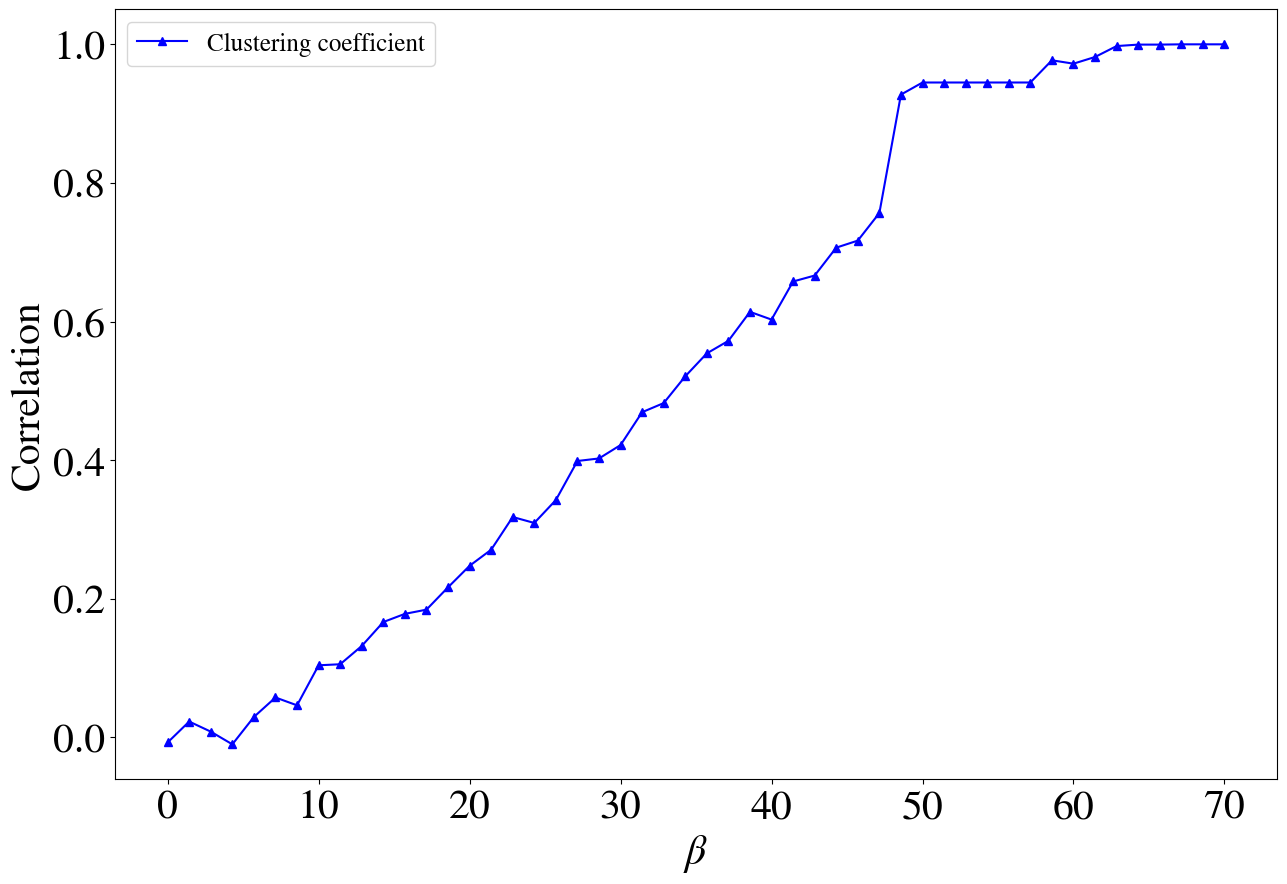

In [77]:
import matplotlib
fig = plt.figure(figsize=(15, 10))
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
cols = ['#666666','#1b9e77','#e7298a','#7570b3',
        '#d95f02','#66a61e','#e6ab02','#a6761d']
#plt.plot(betas, correlations[:, 0], marker='.', color='b')
#plt.plot(betas, correlations4[:, 0], marker='o', color='k', label='Degree')

plt.plot(betas, correlations1[:, 0], marker='^', color='b', label='Clustering coefficient')
#plt.plot(betas, correlations2[:, 0], marker='o', color='g', label='Average Neighbourhood in-degree')
#plt.plot(betas, correlations3[:, 0], marker='x', color='r', label='Betweenness centrality')
#plt.plot(betas, correlations4[:, 0], marker='o', color='k', label='Average Neighbourhood out-degree')
#plt.plot(betas, correlations5[:, 0], marker='s', color='brown', label='Reciprocity')
#plt.fill_between(betas,
#                 correlations1[:, 1],
#                 correlations1[:, 2],
#                 color='b',
#                 alpha=0.5)

plt.xlabel(r'$\beta$', fontsize=30)
plt.ylabel(r'Correlation', fontsize=30)

plt.xticks(fontsize=30) ; plt.yticks(fontsize=30)
plt.legend(prop={'size':18} )
#plt.savefig('eigenvector_correlation_KC.pdf', bbox_inches='tight')



In [ ]:
def log_num_graphs(n, m):
    N = n * (n - 1) // 2
    return (np.math.lgamma(N + 1)
            - np.math.lgamma(m + 1)
            - np.math.lgamma(N - m + 1))

print(log_num_graphs(len(G.nodes), len(G.edges)))

In [81]:
post_burn_in = {}
for b in betas:
    post_burn_in[b] = diffs_by_temp[b][-650000:]


In [ ]:
entropies= compute_entropy_mean(post_burn_in, S0=log_num_graphs(len(G.nodes), len(G.edges)))
Cs = compute_specific_heat_mean(post_burn_in)

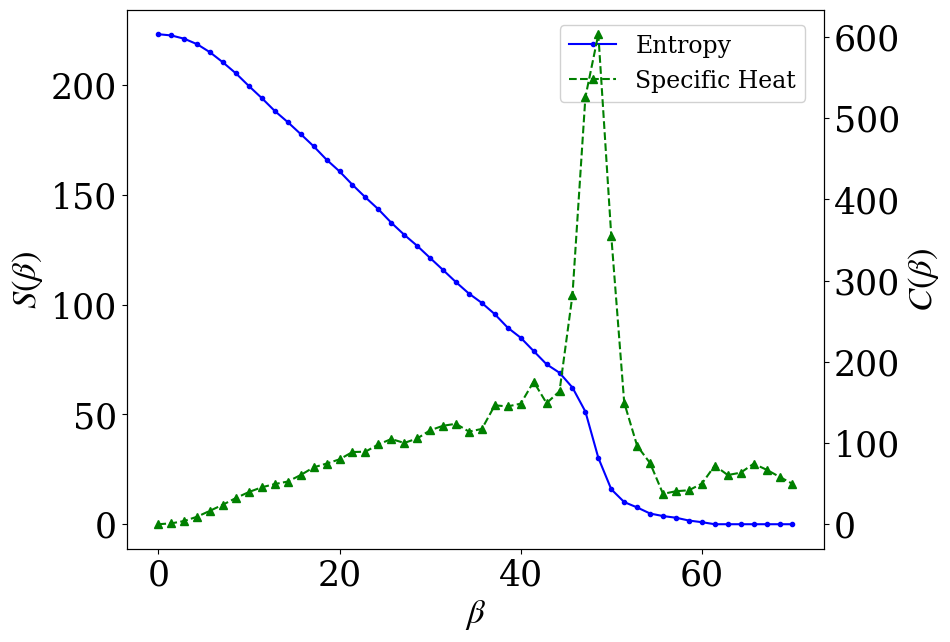

In [87]:
fig, ax1 = plt.subplots(figsize=(9,7))
 
ax1.plot(betas, np.array(list(entropies.values())) , marker='.', color='b', label='Entropy')
ax2 = ax1.twinx()  
ax2.plot(betas, np.array(list(Cs.values())), marker='^', color='g', label='Specific Heat', linestyle='--')
ax1.set_xlabel(r'$\beta$', fontsize=25, font='serif') 
ax1.set_ylabel(r'$S(\beta)$', fontsize=25, font='serif')
ax2.set_ylabel(r'$C(\beta)$', fontsize=25, font='serif')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.tick_params(axis='both', which='both', labelsize=25, labelfontfamily='serif')
ax2.tick_params(axis='both', which='both', labelsize=25, labelfontfamily='serif')

ax1.legend(h1 + h2, l1 + l2,
           loc='upper right',          # corner inside the axes
           bbox_to_anchor=(0.98, 0.98),# slight inset from the top-right
           bbox_transform=ax1.transAxes,
           frameon=True, framealpha=0.9,
           borderaxespad=0.2, prop={'family':'serif', 'size':17} )
#ax1.grid()
#ax2.grid()

#plt.savefig('Entropy and SH2.pdf', bbox_inches='tight')


In [111]:
def CC_correlation(CCs, true):
    corr = np.corrcoef(true, CCs)[0, 1]
    return corr

values3 = np.zeros((len(betas), 3))

centrality = lambda G : nx.degree_assortativity_coefficient(G)

def modularity(G):
    coms = nx.community.louvain_communities(G)
    return nx.community.modularity(G, coms)

def lambda_1(G):
    adj = nx.adjacency_matrix(G).todense()
    l1 = np.linalg.eigvalsh(adj)[-1]
    return l1
    
true3 = centrality(G)

for i in tqdm(range(len(betas))):
    randomised_graphs = sampled_graphs[betas[i]]
    shared = []
    corrs = []
    for j in randomised_graphs:
        corrs.append(centrality(j))
    #for j in range(len(randomised_graphs)):
    #    shared_edges = set(G.edges()).intersection(set(randomised_graphs[j].edges()))
    #    shared.append(len(shared_edges)/len(G.edges))    
    values3[i, 0]  = np.mean(corrs)
    #values3[i, 1:] = np.percentile(corrs, [25, 75])

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 277768.48it/s]


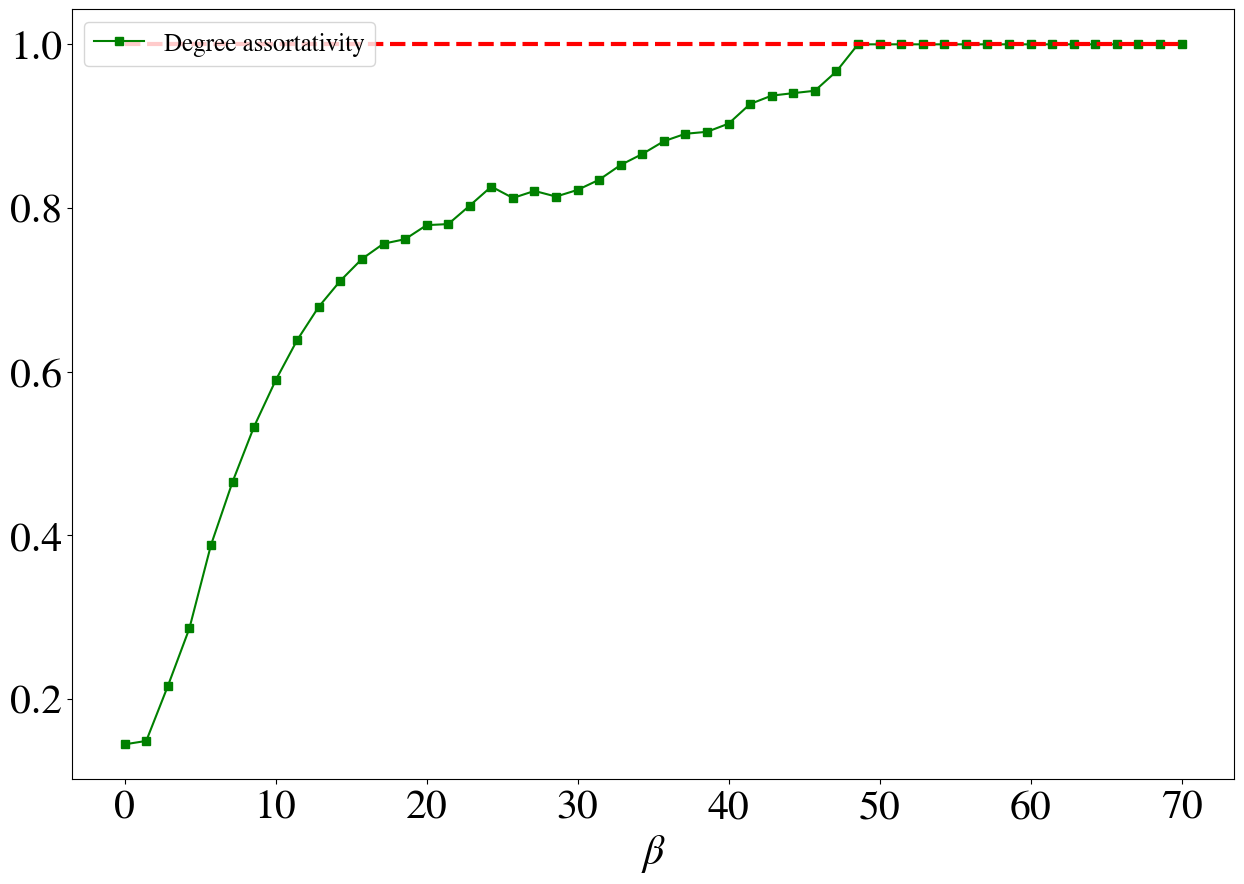

In [91]:
fig = plt.figure(figsize=(15, 10))
#plt.plot(betas, (values1[:, 0])/true1, marker='o', color='k', label='Average shortest path length')
#plt.hlines(true1, betas[0], betas[-1], linestyle='--', color='k', linewidth=2)

#plt.plot(betas, (values2[:, 0])/true2, marker='^',  color='b', label='Reciprocity')
#plt.hlines(true2, betas[0], betas[-1], linestyle='--', color='b', linewidth=2)

plt.plot(betas, (values3[:, 0])/true3, marker='s', color='g', label='Degree assortativity')

#plt.plot(betas, (values4[:, 0])/true4, marker='x', color='purple', label='Transitivity')
#plt.plot(betas, (values5[:, 0])/true5, marker='x', color='magenta', label='Estimated maximum modularity')
#plt.plot(betas, (values6[:, 0])/true6, marker='*', color='brown', label='Leading adjacency eigenvalue')

plt.hlines(1, betas[0], betas[-1], color='r', linestyle='--', linewidth=3)

#plt.fill_between(betas,
#                 values3[:, 1]/true3,
#                 values3[:, 2]/true3,
#                 color='m',
#                 alpha=0.1)

plt.legend()

plt.xlabel(r'$\beta$', fontsize=30)

plt.xticks(fontsize=30) ; plt.yticks(fontsize=30)
plt.legend(prop={'size':18} )

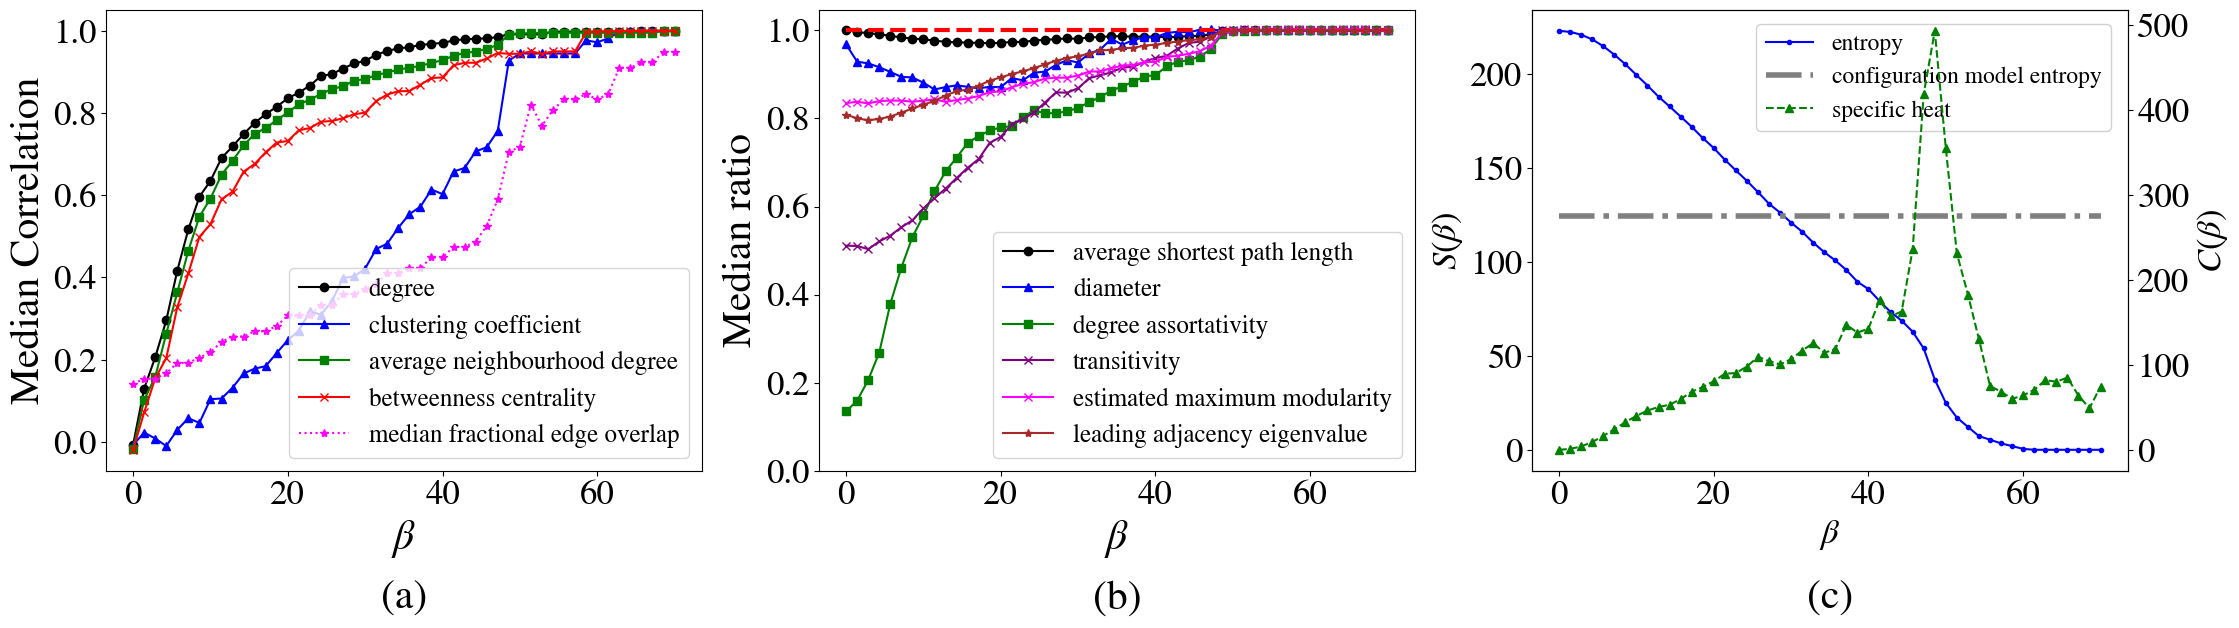

In [117]:
plt.figure(figsize=(22.5,6.5))
plt.subplot(1,3,1)
plt.plot(betas, correlations4[:, 0], marker='o', color='k', label='degree')
plt.plot(betas, correlations1[:, 0], marker='^', color='b', label='clustering coefficient')
plt.plot(betas, correlations2[:, 0], marker='s', color='g', label='average neighbourhood degree')
plt.plot(betas, correlations3[:, 0], marker='x', color='r', label='betweenness centrality')

plt.errorbar(betas, values[:, 0], marker='*', color='magenta', label='median fractional edge overlap', linestyle='dotted')

#plt.fill_between(betas,
#                 values[:, 1],
#                 values[:, 2],
#                 color='magenta',
#                 alpha=0.1)

plt.xlabel(r'$\beta$', fontsize=30)
plt.ylabel(r'Median Correlation', fontsize=30)

plt.xticks([0, 20, 40, 60], fontsize=25) ; plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=25)
plt.legend(prop={'size':18} )
plt.annotate("(a)",
            xy=(0.5, -0.3),   # position below subplot
            xycoords='axes fraction',
            ha='center', fontsize=30)

ax1 = plt.subplot(1,3,2)
#ax2 = ax1.twinx()  
plt.plot(betas, (values1[:, 0])/true1, marker='o', color='k', label='average shortest path length')
#plt.hlines(true1, betas[0], betas[-1], linestyle='--', color='k', linewidth=2)

plt.plot(betas, (values2[:, 0])/true2, marker='^',  color='b', label='diameter')
#plt.hlines(true2, betas[0], betas[-1], linestyle='--', color='b', linewidth=2)

plt.plot(betas, (values3[:, 0])/true3, marker='s', color='g', label='degree assortativity')

plt.plot(betas, (values4[:, 0])/true4, marker='x', color='purple', label='transitivity')

plt.hlines(1, betas[0], betas[-1], color='r', linestyle='--', linewidth=3)
plt.plot(betas, (values5[:, 0])/true5, marker='x', color='magenta', label='estimated maximum modularity')
plt.plot(betas, (values6[:, 0])/true6, marker='*', color='brown', label='leading adjacency eigenvalue')
#ax2.plot(betas, values[:, 0], color='magenta', marker='*', label='Edge overlap', linestyle='dotted')

plt.xlabel(r'$\beta$', fontsize=30)
plt.ylabel(r'Median ratio', fontsize=30)
#ax2.set_ylabel(r'Edge overlap', fontsize=25)

#plt.tick_params(axis='both', which='both', labelsize=25)
plt.xticks([0, 20, 40, 60], fontsize=25) ; plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=25)
#ax2.tick_params(axis='both', which='both', labelsize=25)

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

#ax1.legend(h1 + h2, l1 + l2,
#           loc='upper right',          # corner inside the #axes
#           bbox_to_anchor=(0.98, 0.35),# slight inset from the top-right
#           bbox_transform=ax1.transAxes,
#           frameon=True, framealpha=0.9,
#           borderaxespad=0.2, prop={'size':17} )
plt.legend(prop={'size':18} )
plt.annotate("(b)",
            xy=(0.5, -0.3),   # position below subplot
            xycoords='axes fraction',
            ha='center', fontsize=30)

ax1 = plt.subplot(1, 3, 3)
 
ax1.plot(betas, np.where(np.array(list(entropies.values()))<0, 0,np.array(list(entropies.values()))) , marker='.', color='b', label='entropy')
ax1.hlines(124.35970674542244, betas[0], betas[-1], color='gray', linestyle='dashdot', linewidth=4, label='configuration model entropy')
ax2 = ax1.twinx()  
ax2.plot(betas, np.where(np.array(list(Cs.values()))<0, 0,np.array(list(Cs.values()))), marker='^', color='g', label='specific heat', linestyle='--')
ax1.set_xlabel(r'$\beta$', fontsize=25) 
ax1.set_ylabel(r'$S(\beta)$', fontsize=25)
ax2.set_ylabel(r'$C(\beta)$', fontsize=25)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


ax1.tick_params(axis='both', which='both', labelsize=25)
ax2.tick_params(axis='both', which='both', labelsize=25)

# single legend INSIDE the axes (top-left here)
ax1.legend(h1 + h2, l1 + l2,
           loc='upper right',          # corner inside the axes
           bbox_to_anchor=(0.98, 0.98),# slight inset from the top-right
           bbox_transform=ax1.transAxes,
           frameon=True, framealpha=0.9,
           borderaxespad=0.2, prop={'size':17} )

#ax1.grid()
#ax2.grid()

plt.annotate("(c)",
            xy=(0.5, -0.3),   # position below subplot
            xycoords='axes fraction',
            ha='center', fontsize=30)

plt.tight_layout()

#plt.savefig('KC_statistics3_median.pdf', bbox_inches='tight')


